In [1]:
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from modAL.batch import uncertainty_batch_sampling
from modAL.models import ActiveLearner
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Set our RNG for reproducibility.
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)

iris = load_iris()
X_raw = iris["data"]
y_raw = iris["target"]


In [3]:
# Define our PCA transformer and fit it onto our raw dataset.
pca = PCA(n_components=2, random_state=RANDOM_STATE_SEED)
transformed_iris = pca.fit_transform(X=X_raw)


In [4]:
# Isolate the data we'll need for plotting.
x_component, y_component = transformed_iris[:, 0], transformed_iris[:, 1]


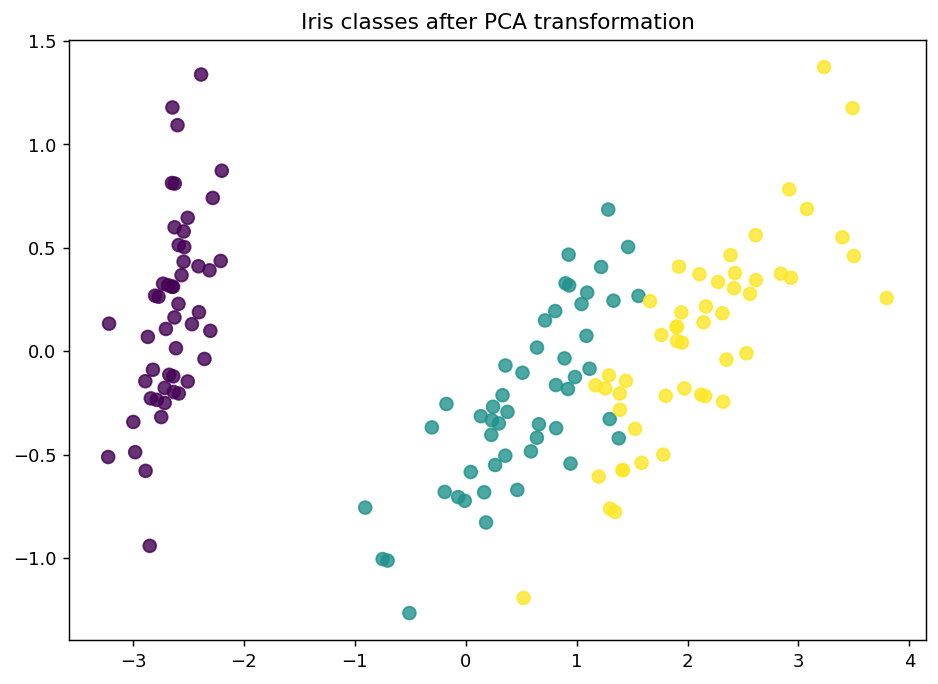

In [5]:
# Plot our dimensionality-reduced (via PCA) dataset.
with plt.style.context("seaborn-v0_8-bright"):
    plt.figure(figsize=(8.5, 6), dpi=130)
    plt.scatter(
        x=x_component, y=y_component, c=y_raw, cmap="viridis", s=50, alpha=8 / 10
    )
    plt.title("Iris classes after PCA transformation")
    plt.show()


In [6]:
# Isolate our examples for our labeled dataset.
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=3)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]


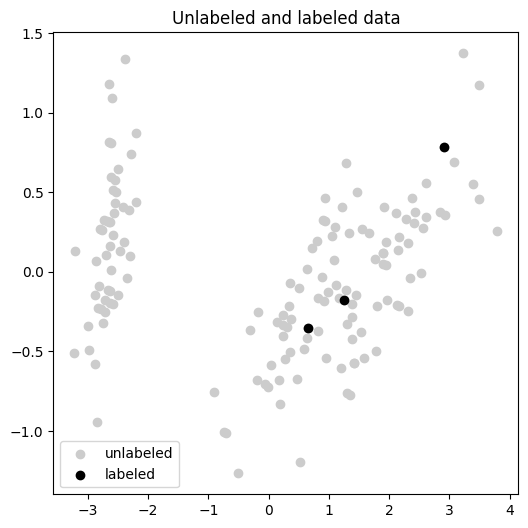

In [7]:
# Visualize the training data.
with plt.style.context("seaborn-v0_8-bright"):
    plt.figure(figsize=(6, 6), dpi=100)
    plt.scatter(
        transformed_iris[:, 0], transformed_iris[:, 1], c="0.8", label="unlabeled"
    )
    plt.scatter(
        transformed_iris[training_indices, 0],
        transformed_iris[training_indices, 1],
        c="k",
        label="labeled",
    )
    plt.title("Unlabeled and labeled data")
    plt.legend()
    plt.show()


In [8]:
# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)


In [9]:
# Specify our core estimator.
knn = KNeighborsClassifier(n_neighbors=3)


In [10]:
# Pre-set our batch sampling to retrieve 3 samples at a time.
BATCH_SIZE = 3
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)


In [11]:
# Specify our active learning model.
learner = ActiveLearner(
    estimator=knn, X_training=X_train, y_training=y_train, query_strategy=preset_batch
)


In [12]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = predictions == y_raw


In [13]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, y_raw)


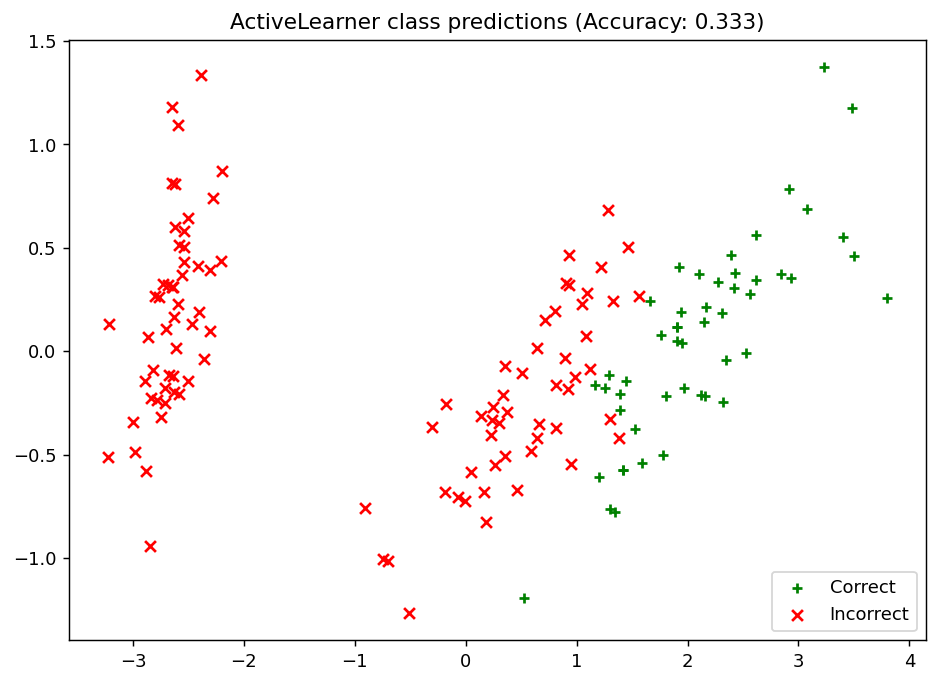

In [14]:
# Plot our classification results.
with plt.style.context("seaborn-v0_8-bright"):
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)
    ax.scatter(
        x=x_component[is_correct],
        y=y_component[is_correct],
        c="g",
        marker="+",
        label="Correct",
    )
    ax.scatter(
        x=x_component[~is_correct],
        y=y_component[~is_correct],
        c="r",
        marker="x",
        label="Incorrect",
    )
    ax.legend(loc="lower right")
    ax.set_title(
        "ActiveLearner class predictions (Accuracy: {score:.3f})".format(
            score=unqueried_score
        )
    )
    plt.show()


Accuracy after query 1: 0.8933


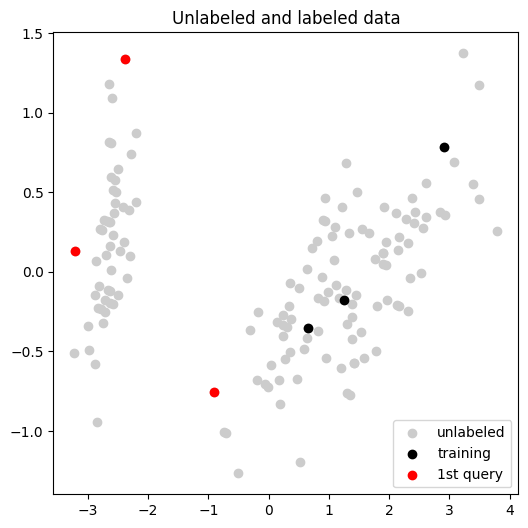

Accuracy after query 2: 0.8400
Accuracy after query 3: 0.9267
Accuracy after query 4: 0.9333
Accuracy after query 5: 0.9467
Accuracy after query 6: 0.9533


In [15]:
# Pool-based sampling
N_RAW_SAMPLES = 20
N_QUERIES = N_RAW_SAMPLES // BATCH_SIZE

performance_history = [unqueried_score]

for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool)

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index], y_pool[query_index]
    learner.teach(X=X, y=y)

    # Remove the queried instance from the unlabeled pool.
    X_pool = np.delete(X_pool, query_index, axis=0)
    y_pool = np.delete(y_pool, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(X_raw, y_raw)
    print(
        "Accuracy after query {n}: {acc:0.4f}".format(n=index + 1, acc=model_accuracy)
    )

    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)

    # Visualize the instances selected for query.
    if index == 0:
        selected = pca.transform(query_instance)

        with plt.style.context("seaborn-v0_8-bright"):
            plt.figure(figsize=(6, 6), dpi=100)
            plt.scatter(
                transformed_iris[:, 0],
                transformed_iris[:, 1],
                c="0.8",
                label="unlabeled",
            )
            plt.scatter(
                transformed_iris[training_indices, 0],
                transformed_iris[training_indices, 1],
                c="k",
                label="training",
            )
            plt.scatter(selected[:, 0], selected[:, 1], c="r", label="1st query")
            plt.title("Unlabeled and labeled data")
            plt.legend()
            plt.show()



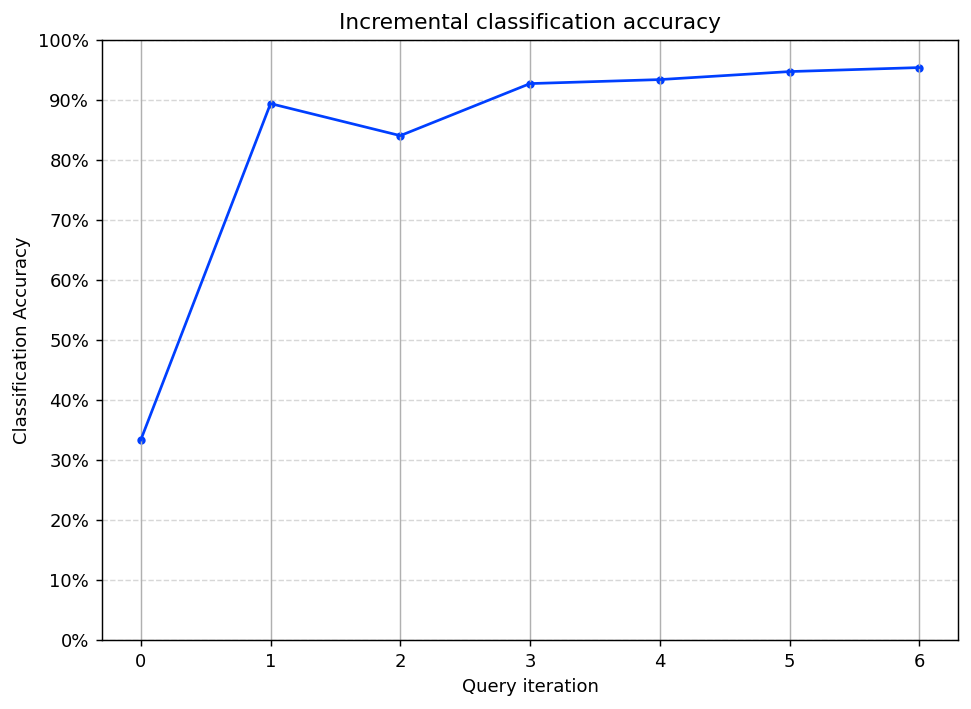

In [16]:
# Plot our performance over time.
with plt.style.context("seaborn-v0_8-bright"):
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

    ax.plot(performance_history)
    ax.scatter(range(len(performance_history)), performance_history, s=13)

    ax.xaxis.set_major_locator(
        mpl.ticker.MaxNLocator(nbins=N_QUERIES + 3, integer=True)
    )
    ax.xaxis.grid(True)

    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10))
    ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
    ax.set_ylim(bottom=0, top=1)
    ax.yaxis.grid(True, linestyle="--", alpha=1 / 2)

    ax.set_title("Incremental classification accuracy")
    ax.set_xlabel("Query iteration")
    ax.set_ylabel("Classification Accuracy")

    plt.show()


In [17]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = predictions == y_raw


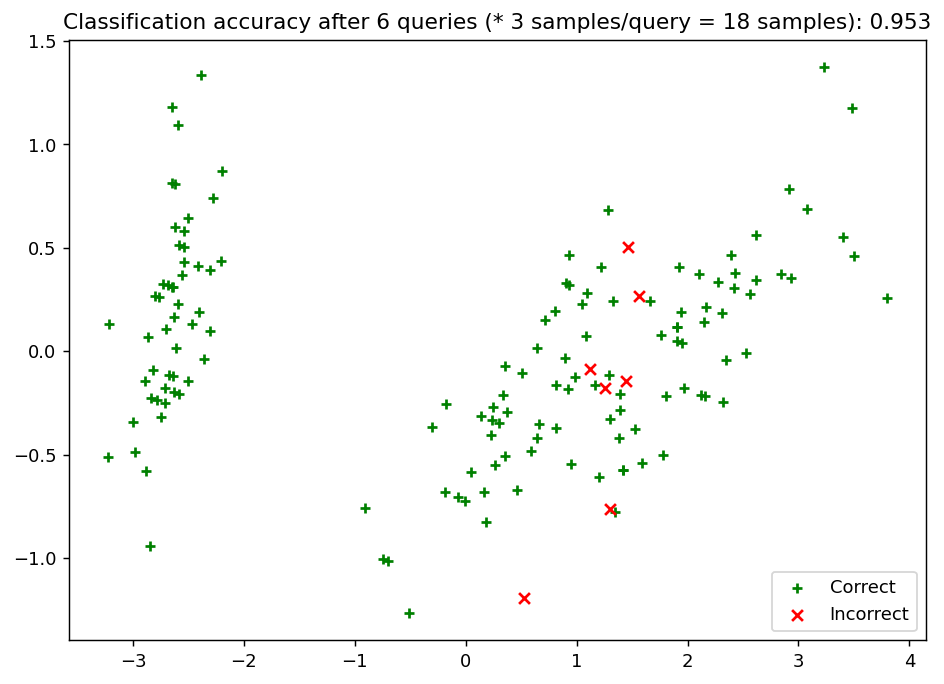

In [18]:
# Plot our updated classification results once we've trained our learner.
with plt.style.context("seaborn-v0_8-bright"):
    fig, ax = plt.subplots(figsize=(8.5, 6), dpi=130)

    ax.scatter(
        x=x_component[is_correct],
        y=y_component[is_correct],
        c="g",
        marker="+",
        label="Correct",
    )
    ax.scatter(
        x=x_component[~is_correct],
        y=y_component[~is_correct],
        c="r",
        marker="x",
        label="Incorrect",
    )

    ax.set_title(
        "Classification accuracy after {n} queries (* {batch_size} samples/query = {total} samples): {final_acc:.3f}".format(
            n=N_QUERIES,
            batch_size=BATCH_SIZE,
            total=N_QUERIES * BATCH_SIZE,
            final_acc=performance_history[-1],
        )
    )
    ax.legend(loc="lower right")

    plt.show()
